In [3]:
import pylab
import matplotlib.pyplot as plt 
import numpy as np
from matplotlib import gridspec
from ipywidgets import interact, interactive, fixed
from sklearn.pipeline import Pipeline
from sklearn import ensemble
import ipywidgets as widgets
import pickle
import itertools
import os
import copy

import sklearn as skl
from sklearn import datasets
import torch
from nerus import load_nerus

np.random.seed(1)
import random

In [4]:
docs = load_nerus('nerus/nerus_lenta.conllu.gz')

Вы построили базовые (слабые) модели машинного обучения под вашу задачу. Некоторые задачи показали себя не очень, некоторые показали себя хорошо. Как выяснилось, вашим инвесторам показалось этого мало и они хотят, чтобы вы построили модели посерьезней и поточнее. Вы вспомнили,  что когда то вы проходили курс машинного обучения и слышали что есть способ улучшить результаты вашей задачи: ансамбли: беггинг, пастинг, бустинг и стекинг,  а также классификация путем жесткого и мягкого голосования и вы решили это опробовать. Требования к написанным классам вы оставляете теми же, что и в предыдущей работе. Будьте аккуратны в оптимизации целевой метрики и учитывайте несбалансированность классов. Требования к отчету сохраняются такими же)

Ваша задача:
1. Используя модели которые вы реализовали в предыдущей лабораторной работе, реализовать два подхода для построения ансамблей: жесткое и мягкое голосование, однако учтите, некоторые модели не предусматривают оценку вероятностей, например SVM и потому вам необходимо будет оценивать вероятности
2. Реализовать дерево решений
4. Реализовать случайный лес
3. Воспользоваться готовой коробочной реализацией градиентного бустинга для решения вашей задачи
Для всех моделей провести fine-tuning.

### Алгоритмы. Реализация и тестирование

#### Искуственный датасет для классификации:

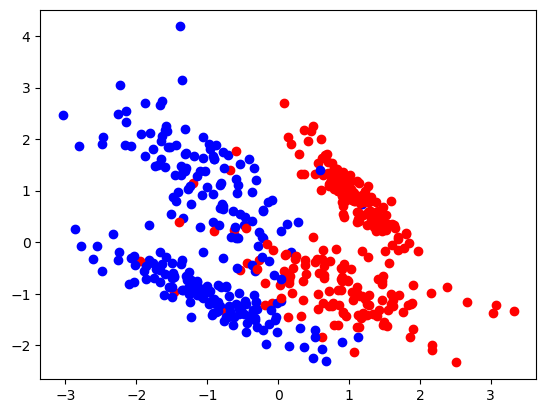

In [5]:
clm = datasets.make_classification(n_samples = 500,n_features = 2,n_informative = 2,n_redundant = 0,class_sep = 1,flip_y=0.05)

#генерация выборок
trainXX,valXX = (np.split(clm[0],[int(8*len(clm[0])/10)]))
trainLB,valLB = (np.split(clm[1],[int(8*len(clm[1])/10)]))

train_X = np.array([[t[0],t[1],1] for i,t in enumerate(trainXX)])

pos_examples = np.array([ [t[0],t[1],1] for i,t in enumerate(trainXX) 
                          if trainLB[i]>0])
neg_examples = np.array([ [t[0],t[1],1] for i,t in enumerate(trainXX) 
                          if trainLB[i]<1])
#визуализация
for i in range(len(clm[1])):
    if(clm[1][i] > 0):
        plt.plot(clm[0][i][0],clm[0][i][1],'ro')
    if(clm[1][i] < 1):
        plt.plot(clm[0][i][0],clm[0][i][1],'bo')

plt.show()

#### Метрики

In [6]:
#кривая порог - точность
#очень помогает определить оптимальный дискриминант

def DAC(model,data,labels,d_span = [0,1]):
    real_d = model.d
    
    line_x = []
    line_y = []
    
    for d in range(100*d_span[0],100*d_span[1]):
        di = d*0.01
        model.set_d(di)
        line_x.append(di)
        line_y.append(model.accuracy(data,labels))
    
    pylab.grid()
    pylab.xlim(d_span[0], d_span[1])
    pylab.ylim(0,1)   
    pylab.xlabel('d (порог)')
    pylab.ylabel('accuracy')
    pylab.plot(line_x,line_y)
    
    model.set_d(real_d)
    
#кривая порог - точность
#очень помогает определить оптимальный дискриминант

def DACforPipe(model,data,labels,d_span = [0,1]):
    real_d = model[1].d
    
    line_x = []
    line_y = []
    
    for d in range(100*d_span[0],100*d_span[1]):
        di = d*0.01
        model[1].set_d(di)
        line_x.append(di)
        line_y.append(model.score(data,labels))
    
    pylab.grid()
    pylab.xlim(d_span[0], d_span[1])
    pylab.ylim(0,1)   
    pylab.xlabel('d (порог)')
    pylab.ylabel('accuracy')
    pylab.plot(line_x,line_y)
    
    model[1].set_d(real_d)

In [7]:
def basic_metrics(model,data,labels,silent = True):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    for i in range(len(labels)):
        res = model.predict([data[i]])
        if(res == labels[i] and res == 1):
            TP += 1
        if(res == labels[i] and res == 0):
            TN += 1
        if(res != labels[i] and res == 1):
            FP += 1
        if(res != labels[i] and res == 0):
            FN += 1
            
    accuracy = (TP + TN)/(TP + TN + FP + FN)
    if(TP + FP == 0):
        precision = 0
    else:
        precision = TP/(TP + FP)
    recall = TP/(TP + FN)
    specificity = TN/(TN + FP)
    sencitivity = TP/(TP + FN)
    
    if(not silent):
        print("accuracy: {} (чем больше ложных, тем меньше)".format(accuracy))
        print(
            "precision: {} (чем больше ложнопозитивных, тем меньше)".format(precision))
        print("recall: {} (чем больше ложнонегативных, тем меньше)".format(recall))
        print("specificity: {} (чем больше негативных классифицировано неверно, тем меньше)".format(specificity))
        print("sencitivity: {} (чем больше позитивных классифицировано неверно, тем меньше)".format(sencitivity))
    
    return (accuracy,precision,recall,specificity,sencitivity)

In [8]:
def roc(model,data,labels,d_span = [0,1],unlock_borders = False):
    real_d = model.d
    
    line_x = []
    line_y = []
    
    for d in range(100*d_span[0],100*d_span[1]):
        di = d*0.01
        model.set_d(di)
        line_x.append(1 - basic_metrics(model,data,labels)[3])
        line_y.append(basic_metrics(model,data,labels)[4])
    
    pylab.grid()
    if not (unlock_borders):
        pylab.xlim(0, 1)
        pylab.ylim(0, 1)   
    pylab.xlabel('1 - specificity')
    pylab.ylabel('sencitivity')
    pylab.plot(line_x,line_y)
    pylab.plot([0,1],[0,1], 'g-')
    
    model.set_d(real_d)
    
def rocForPipe(model,data,labels,d_span = [0,1],unlock_borders = False):
    real_d = model[1].d
    
    line_x = []
    line_y = []
    
    for d in range(100*d_span[0],100*d_span[1]):
        di = d*0.01
        model[1].set_d(di)
        line_x.append(1 - basic_metrics(model,data,labels)[3])
        line_y.append(basic_metrics(model,data,labels)[4])
    
    pylab.grid()
    if not (unlock_borders):
        pylab.xlim(0, 1)
        pylab.ylim(0, 1)   
    pylab.xlabel('1 - specificity')
    pylab.ylabel('sencitivity')
    pylab.plot(line_x,line_y)
    pylab.plot([0,1],[0,1], 'g-')
    
    model[1].set_d(real_d)

In [9]:
def confusion_matrix(model, data, labels,
                     class_names,
                     normalize=False,
                     title='Confusion matrix',
                     do_print = True,
                     shrink = 1):
    #реультат классификации
    predicted_lb = []
    for a in data:
        predicted_lb.append(model.predict([a]))
    #построение матрицы
    n_cl = len(np.unique(labels))
    matr = np.zeros([n_cl,n_cl])
    for i in range (len(labels)):
        matr[labels[i],predicted_lb[i]] += 1
    #отображение матрицы    
    pylab.imshow(matr, interpolation='nearest', cmap=pylab.cm.Blues)
    pylab.title(title)
    pylab.colorbar()
    tick_marks = np.arange(len(class_names))
    pylab.xticks(tick_marks, class_names, rotation=45)
    pylab.yticks(tick_marks, class_names)

    matr = (matr.astype('float')/shrink).astype('int')
    
    if normalize:
        matr = matr.astype('float') / matr.sum(axis=1)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    
    thresh = matr.max() / 2.
    if(do_print):
        for i, j in itertools.product(range(matr.shape[0]), range(matr.shape[1])):
              pylab.text(j, i, np.round((matr[i, j]),2),
                    color="white" if matr[i, j] > thresh else "black")
                
    pylab.ylabel('True label')
    pylab.xlabel('Predicted label')
    pylab.show()

#### Модели

In [10]:
class linear_regression(skl.base.ClassifierMixin):
    
    def __init__(self,n_feat,lr = 0.05,d = 0):
        self.w = np.zeros(n_feat + 1)
        self.d = d
        self.lr = lr
        
    def wts(self):
        return self.w
    
    def set_d(self,new_d):
        self.d = new_d
        
    def predict(self,feats_): # кассификация (положительный/отрицательный результат в зависимости от того, 
                              # преодолевает ли предстказанное значение дискриминант)
        feats = feats_[0]
        
        score = np.sum((np.dot(feats,self.w[0:len(feats)])))
        
        return int(score > self.d)
    
    def linres(self,feats_): # предсказанное значение f(feats)
        feats = feats_[0]
        
        score = np.sum((np.dot(feats,self.w[0:len(feats)])))
        
        return score
            
    def accuracy(self,data,labels):
        total = 0
        correct = 0
        for i in range(len(labels)):
            total += 1
            if(self.predict([data[i]]) == labels[i]):
                correct += 1
        return correct/total
    
    def score(self,data,labels):
        return self.accuracy(data,labels)
    
    def fit(self,data,labels,rr = 50):
        self.w = np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(np.matrix(data)),
                                                    np.matrix(data))),
                              (np.transpose(np.matrix(data)))),
                        np.transpose(np.matrix(labels)))

In [11]:
class logistic_regression(skl.base.ClassifierMixin):
    
    def __init__(self,n_feat,lr = 0.1,d = 0.5,verbal = False):
        self.verbal = verbal
        self.w = np.zeros(n_feat + 1)
        self.d = d
        self.lr = lr
        
    def wts(self):
        return self.w
        
    def predict(self,feats_,d = -1):
        feats = feats_[0]
        
        score = np.sum(np.dot(self.w[0:len(feats)],feats))
        
        if(d == -1 or (d < 0) or (d > 1)):
            d = self.d
        prob = 1/(1 + np.exp(-score))
        
        return int(prob > d)
    
    def logit(self,feats_):
        feats = feats_[0]
        
        score = np.sum(np.dot(self.w[0:len(feats)],feats))
        return 1/(1 + np.exp(-score))
    
    def set_d(self,new_d):
        self.d = new_d
     
    def accuracy(self,data,labels):
        total = 0
        correct = 0
        for i in range(len(labels)):
            total += 1
            if(self.predict([data[i]]) == labels[i]):
                correct += 1
        return correct/total
    
    def score(self,data,labels):
        return self.accuracy(data,labels)
    
    def fit(self,data,labels,rr = 50):
        
        if(rr == 0):
            rr = len(labels) + 1
        print("")
        
        for i in range(len(labels)):
            lr = self.lr
                        
            sc = self.logit([data[i]])
            self.w += (labels[i] - sc)*data[i]*lr

In [12]:
class SVM(skl.base.ClassifierMixin):
    
    def __init__(self,n_feat,lr = 0.05,d = 0.9):
        self.w = np.zeros(n_feat + 1)
        self.d = d
        self.lr = lr
        
    def wts(self):
        return self.w
        
    def predict(self,feats_):
        feats = feats_[0]
        
        score = np.sum(np.dot(self.w[0:len(feats)],feats))
        
        prob = 1/(1 + np.exp(-score))
        
        return int(prob > self.d)
    
    def set_d(self,new_d):
        self.d = new_d
    
    def accuracy(self,data,labels):
        total = 0
        correct = 0
        for i in range(len(labels)):
            total += 1
            if(self.predict([data[i]]) == labels[i]):
                correct += 1
        return correct/total
    
    def score(self,data,labels):
        return self.accuracy(data,labels)
        
    def fit(self,data,labels, alpha = 0.1,silent = True):
                
        for i in range(len(labels)):
            lr = self.lr
            
            cl = self.predict([data[i]])
            
                   
            if(cl < self.d and labels[i] == 1):
                self.w += (data[i])*lr
            
            if(cl > self.d and labels[i] == 0):
                self.w -= (data[i])*lr 
                
            self.w += alpha * self.w * lr
    

In [13]:
class KNN(skl.base.ClassifierMixin): #svm (soft-margin)
    
    def __init__(self,k = 5,return_probability = False):
        
        self.return_probability = return_probability
        if(k % 2 == 0):
            k+=1
            
        if(k <= 0):
            return -1
            
        self.k = k
    
    def set_return_probability(self,do_return_probability):
        self.return_probability = do_return_probability
        
    def set_d(self,new_d):
        self.k = new_d
              
    def predict(self,feats_,silent = True):
        feats = feats_[0]
        
        mins = np.zeros([self.k,2]) - 1
        mqs = []
        
        j=0
        for cur in self.examples:
            j += 1
            dist = np.linalg.norm(feats - cur[0]) #расстояние между точками
            
            for i in range(len(mins)):
                if(dist < mins[i][0] or mins[i][0] < 0):
                    mins[i][0] = dist
                    mins[i][1] = cur[1]
                    mqs.append(cur[0])
                    break
                    
        
        score = np.zeros(len(self.classes))
        for a in mins:
            score[int(a[1])] += 1
                          
        if(not silent):
            print("---------")
            print("input feats: {}".format(feats))
            print("closest obj: {}".format(mqs[len(mqs) - self.k : len(mqs)]))
            
            return (np.argmax(score)),(mqs[len(mqs) - self.k : len(mqs)])
        
        if(self.return_probability):
            res = [np.argmax(score),score[np.argmax(score)]/np.sum(score)]
        else:
            res = np.argmax(score)
            
        return res
              
    def accuracy(self,data,labels):
        total = 0
        correct = 0
        for i in range(len(labels)):
            total += 1
            
            if(self.return_probability):
                if(self.predict([data[i]])[0] == labels[i]):
                    correct += 1
            else:     
                if(self.predict([data[i]]) == labels[i]):
                    correct += 1
        return correct/total    
    
    
    def score(self,data,labels):
        return self.accuracy(data,labels)
    
    def fit(self,data,labels):          
        self.examples = []
        for i in range(len(data)):
            self.examples.append([data[i],labels[i]])
        self.examples = np.array(self.examples,dtype=object)
        self.classes = np.unique(labels)

In [14]:
class Naive_Bayes(skl.base.ClassifierMixin): 
    #базовый наивный байесовский алгоритм
    def __init__(self,verbal = False,return_probability = False):
        self.return_probability = return_probability
        self.verbal = verbal
                
    def set_return_probability(self,do_return_probability):
        self.return_probability = do_return_probability
        
    def predict(self,feats_,silent = True):
        feats = feats_[0]
        score = copy.deepcopy(self.cl_freq)
        
        for i in range(len(score)):
            for cur in feats:
                if(np.array(cur,dtype = np.intc).tolist() in self.uni.tolist()):
                    score[i] *= self.feat_freq[i][self.uni.tolist().index(np.array(cur,dtype = np.intc).tolist())]
        
        if(self.return_probability):
            cl = [np.argmax(score) , score[np.argmax(score)]]
        else:
            cl = np.argmax(score)
        
        return cl
        
    def _score(self,feats_):
        feats = feats_[0]
        score = copy.deepcopy(self.cl_freq)
        
        for i in range(len(score)):
            for cur in feats:
                if(np.array(cur,dtype = np.intc).tolist() in self.uni.tolist()):
                    score[i] *= self.feat_freq[i][self.uni.tolist().index(np.array(cur,dtype = np.intc).tolist())]
        return score
      
    def accuracy(self,data,labels):
        total = 0
        correct = 0
        for i in range(len(labels)):
            total += 1
            if(self.return_probability):
                if(self.predict([data[i]])[0] == labels[i]):
                    correct += 1
            else:     
                if(self.predict([data[i]]) == labels[i]):
                    correct += 1
        return correct/total  
    
    def score(self,data,labels):
        return self.accuracy(data,labels)
    
    def status(self):
        print("classes | freq:")
        print(self.cl_freq)
        print("features | freq: ")
        print(self.feat_freq)
        
    def fit(self,data,labels,wts = None):
                               #должны учитываться только признаки, которые есть во всех классах
                
        #data представляет из себя массив массивов возмможно переменной длины,
        #в каждом из которых находятся теги, принадл. данному эементу
        
        self.cl_freq = np.zeros(np.max(labels) + 1)
        for i in labels:
            self.cl_freq[i] += 1
            
        #список уникальных признаков
        #признаками считаются элементы массива признаков целиком 
        #([[1,2],[3,4]) - признак №1 = [1,2], признак №2 = [3,4]
        
        self.uni = []
        for cur in data:
            for a in cur:
                b = np.array(a,dtype = np.intc).tolist()
                if not b in self.uni:
                    self.uni.append(b)
        self.uni = np.array(self.uni)
        
        if(self.verbal):
            print(self.uni)
        #частоты признаков в классах
        self.feat_freq = np.zeros([len(self.cl_freq),len(self.uni)])
        
        for i in range(len(labels)):
            
            if(np.array(wts == None).all()):
                add = 1
            else:
                add = wts[i]
            
            for j in range(len(data[i])):
                #в списке уникальных признаков находим текущий признак, и по его индексу инкриментируем элемент в списке частотности признаков в классах
                
                self.feat_freq[int(labels[i])][self.uni.tolist().index(np.array(data[i][j],dtype = np.intc).tolist())] += add
        
        if(self.verbal):
            print(self.cl_freq)
            print(self.feat_freq)

### Подготовка данных

In [15]:
Classes = []
selLen = 1000

for i in range (selLen): #рассматриваем первые 1000 документов собираем данные по словам и тегам в массивы
    doc = next(docs)
    for sent in doc.sents:
        for token in sent.tokens:
            if(token.pos != "X" and token.pos != "PUNCT" and token.pos != "SYM" and 
               token.pos != "AUX" and token.pos != "NUM" and token.pos != "SCONJ"  and 
               token.pos != "PRON" and token.pos != "DET" and token.pos != "PROPN" and 
               token.pos != "INTJ"):
                
                 if(not token.pos in Classes): #на всякий случай
                        Classes.append(token.pos)

docs = load_nerus('nerus/nerus_lenta.conllu.gz') # "сдвигаем" итератор в начало

Classes

['NOUN', 'ADP', 'ADJ', 'VERB', 'ADV', 'CCONJ', 'PART']

In [16]:
ClassesRU = ["СУЩ","ПРЕД","ПРИЛ","ГЛАГ","НАР","СЧСОЮЗ","ПРИЧ"]

def ClassConvToRU(cl):
    for i in range(len(Classes)):
        if(cl == Classes[i]):
            return ClassesRU[i]
        
def ClassConvToEN(cl):
    for i in range(len(Classes)):
        if(cl == ClassesRU[i]):
            return Classes[i]
        
def classnum(cl): #перевод из имен классов в индексы
    for i in range(len(Classes)):
        if(cl == Classes[i]):
            return i
    return -1

In [17]:
alphabet = ['а', 'е', 'ё', 'и', 'о', 'у', 'ы', 'э', 'ю', 'я', 
            'б', 'в', 'г', 'д', 'ж', 'з', 'й', 'к', 'л', 'м', 'н', 'п', 'р', 'с', 'т', 'ф', 'х', 'ц', 'ч', 'ш', 'щ',
            'ь', 'ъ']

def LetterPos(l):
    try: 
        return alphabet.index(l)
    except(BaseException):
        return -1
    
def wordAsArray(word):
    res = []
    for cur in word:
        res.append(LetterPos(cur))
    return res

def boolArr(letter): #создать zeros-like по алфавиту с 1 в индексе данной буквы
    arr = []
    for a in alphabet:
        if(a == letter):
            arr.append(1)
        else:
            arr.append(0)
            
    return np.array(arr)

count of classes in dataset:


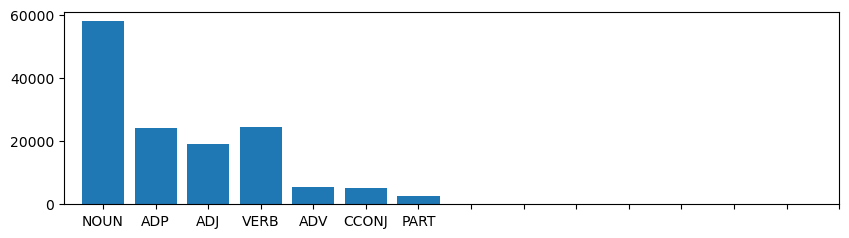

averege len:


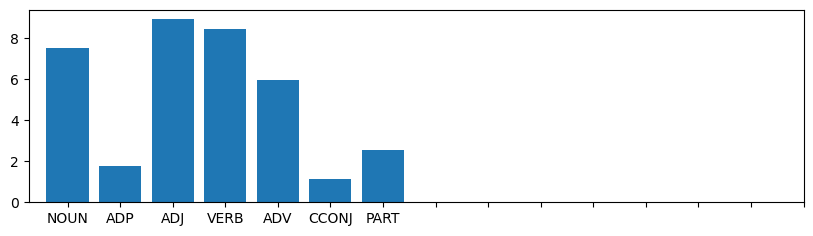

In [18]:
CllenAvg = [0 for i in range(len(Classes))] #среднее значение длины слова соответствующего класса
ClCnt = [0 for i in range(len(Classes))] #сколько слов каждого класса встретилось

for i in range (selLen): #рассматриваем первые 1000 документов собираем данные по словам и тегам в массивы
    doc = next(docs)
    for sent in doc.sents:
        for token in sent.tokens:
            if(token.pos in Classes):
                clN = classnum(token.pos)
                CllenAvg[clN] += len(token.text)
                ClCnt[clN] += 1
                
for i in range(len(Classes)):
    CllenAvg[i] /= ClCnt[i]

docs = load_nerus('nerus/nerus_lenta.conllu.gz') # "сдвигаем" итератор в начало

print("count of classes in dataset:")
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(2.5) 

ax.bar(Classes,ClCnt)
pylab.xticks(np.arange(15))
pylab.show()

print("averege len:")
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(2.5) 

ax.bar(Classes,CllenAvg)
pylab.xticks(np.arange(15))
pylab.show()

### Составление датасета

In [19]:
def create_dataset(selLen = 5000,ClLen = 500):
    #W равное число экземпляров каждого класса
    #по 5000

    ClCnt = [0 for i in range(len(Classes))]

    larrLB = []
    larrDC = [] #сами слова
    
    docs = load_nerus('nerus/nerus_lenta.conllu.gz') # "сдвигаем" итератор в начало

    for i in range (selLen): #рассматриваем первые 1000 документов собираем данные по словам и тегам в массивы
        doc = next(docs)
        for sent in doc.sents:
            for token in sent.tokens:
                if(token.pos in Classes):
                        clN = classnum(token.pos)

                        if(ClCnt[clN] < ClLen):

                            ClCnt[clN] += 1

                            larrLB.append(classnum(token.pos)) #мб стоит преобразовать в численный тег))])
                            larrDC.append(token.text) #



    ClCnt = [0 for i in range(len(Classes))]

    tarrLB = []
    tarrDC = [] #сами слова

    for i in range (selLen): #рассматриваем первые 1000 документов собираем данные по словам и тегам в массивы
        doc = next(docs)
        for sent in doc.sents:
            for token in sent.tokens:
                if(token.pos in Classes):
                        clN = classnum(token.pos)

                        if(ClCnt[clN] < ClLen):

                            ClCnt[clN] += 1

                            tarrLB.append(classnum(token.pos)) #мб стоит преобразовать в численный тег))])
                            tarrDC.append(token.text) #

    docs = load_nerus('nerus/nerus_lenta.conllu.gz') # "сдвигаем" итератор в начало

    return larrLB,larrDC,tarrLB,tarrDC

In [20]:
larrLB,larrDC,tarrLB,tarrDC = create_dataset()

In [21]:
def CarArr(_word,mult = 1):
    word = copy.deepcopy(_word)
    
    if(len(word) < 3):
        res = np.array([
                        len(word),
                        LetterPos(word[0])*mult,
                        LetterPos(('a'))*mult,
                        LetterPos((word[len(word) - 2]))*mult,
                        LetterPos((word[len(word) - 1]))*mult
                        ], dtype = object)
    else:
        res = np.array([
                        len(word),
                        LetterPos(word[0])*mult,
                        LetterPos((word[len(word) - 3]))*mult,
                        LetterPos((word[len(word) - 2]))*mult,
                        LetterPos(word[len(word) - 1])*mult
                        ], dtype = object)
    return res

#### Две лучшие модели из л.р.1:

## NB

In [22]:
class transform(skl.base.TransformerMixin):
    
    def fit(self,a,b):
        return self
    
    def transform(self,a):
        res = copy.deepcopy(a)
        for i in range(len(a)):
            res[i] = CarArr(a[i])
            
        return res

accuracy on train set:
0.6931428571428572
accuracy on test set:
0.6711428571428572
train set:
Confusion matrix, without normalization


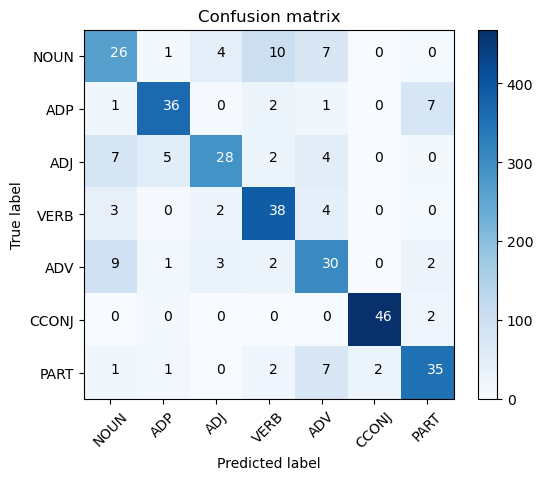

test set:
Confusion matrix, without normalization


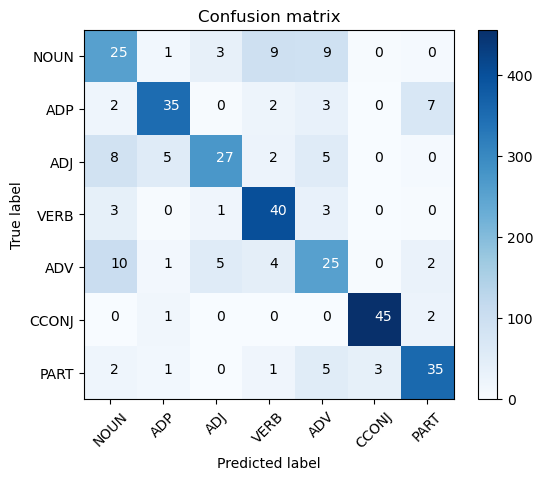

In [21]:
pipe = Pipeline([('transformer',transform()),('classifier',Naive_Bayes())])
pipe.fit(larrDC,larrLB)
pipe = Pipeline([('transformer',transform()),('classifier',Naive_Bayes())])
pipe.fit(larrDC,larrLB)

print("accuracy on train set:")
print(pipe.score(larrDC,larrLB))
print("accuracy on test set:")
print(pipe.score(tarrDC,tarrLB))

print("train set:")
confusion_matrix(pipe,larrDC,larrLB,class_names = Classes,normalize = False,shrink = 10)
print("test set:")
confusion_matrix(pipe,tarrDC,tarrLB,class_names = Classes,normalize = False,shrink = 10)

Видно, что ключевыми признакими для успешной классификации являются длина и последняя буква. Дальнейшее увеличение количества рассматриваемых букв медленно увеличивает точность.

## KNN

In [22]:
larrLB,larrDC,tarrLB,tarrDC = create_dataset(ClLen = 100)

In [23]:
class transform(skl.base.TransformerMixin):
    
    def __init__(self,n = 1):
        self.n = n
    
    def fit(self,a,b):
        return self
    
    def transform(self,a):
        res = copy.deepcopy(a)
        for i in range(len(a)):
            res[i] = CarArr(a[i], mult = self.n)
            
        return np.array(res)

accuracy on train set:
0.99
accuracy on test set:
0.7542857142857143
train set:
Confusion matrix, without normalization


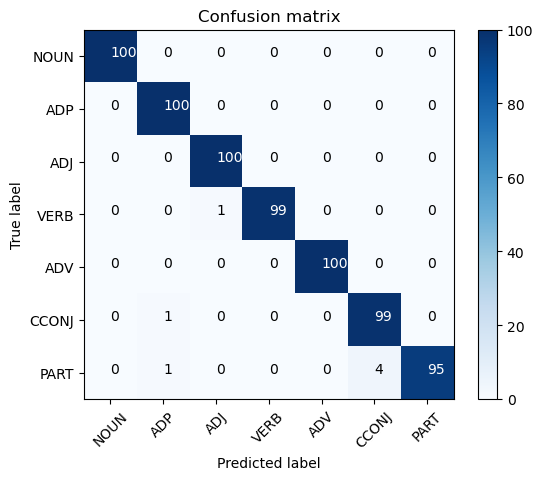

test set:
Confusion matrix, without normalization


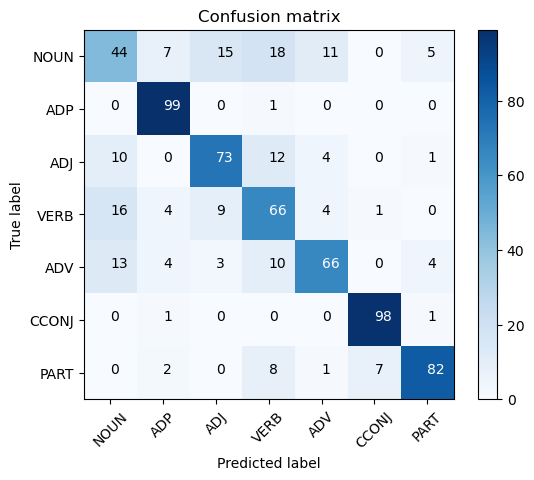

In [24]:
pipe = Pipeline([('transformer',transform(n = 6)),('classifier',KNN(k = 1))])
pipe.fit(larrDC,larrLB)

print("accuracy on train set:")
print(pipe.score(larrDC,larrLB))
print("accuracy on test set:")
print(pipe.score(tarrDC,tarrLB))

print("train set:")
confusion_matrix(pipe,larrDC,larrLB,class_names = Classes,normalize = False,shrink = 1)
print("test set:")
confusion_matrix(pipe,tarrDC,tarrLB,class_names = Classes,normalize = False,shrink = 1)

# Ансамбли

Выводы точности (score) ансамблей имеют следующую структуру:  
[ точность ансамбля,точность базового алгоритма 1, точность базового алгоритма 2, ... , точность базового алгоритма n ]

## Стакинг:

Выборка бьется на число алгоритмов + 1, базовые алгоритмы обучаются каждый на своей подвыборке, метаалгоритм обучается на результатах базовых алгоритмов на дополнительной подвыборке. Базовые алгоритмы могут быть разнородными.

In [89]:
class Stacking(skl.base.ClassifierMixin):
    def __init__(self,base_mods,metamod):
        self.base_models = base_mods
        self.metamodel = metamod
        
        self.spl_cnt = len(self.base_models) + 1
        
    def accuracy(self,data,labels,verbal = False):
        data,labels = skl.utils.shuffle(data,labels)    
        accuracy_base = []
        for i in range(len(self.base_models)):    
            accuracy_base.append(self.base_models[i].score(data,labels))
                        
        base_res_pre = []
        for i in range(len(self.base_models)):
            cur_res = []
            for a in data:
                cur_res.append(self.base_models[i].predict([a]))
            base_res_pre.append(cur_res)
                            
        base_res = np.array([np.array(base_res_pre)[:,i] for i in range(len(base_res_pre[0]))])
        base_res_feats = np.array(base_res)
        
        accuracy_meta = self.metamodel.score(np.array(base_res_feats),labels)
        
        errors = 0
        fair = 0
        for i in range(len(base_res_feats)):
            predl = self.metamodel.predict([base_res_feats[i]])
            if(predl != labels[i]):
                errors += 1
                if(verbal):
                    print("base: {} pred: {} act: {}".format(base_res[i],predl,labels[i]))
                if(predl == base_res[i][0] or (predl == base_res[i][1])):
                    #предположил класс, один из коих был в базовой классификации
                    fair += 1
        if(verbal):
            print("errors: {} fair: {} fair part: {}".format(errors,fair,fair/errors))
        
        res = [accuracy_meta]
        for i in accuracy_base:
            res.append(i)
        
        return np.array(res)
    
    def predict(self,data):
        pre_res = []
        for mod in self.base_models:
            pre_res.append(mod.predict([data]))
                                    
        base_res = np.array(pre_res)
        
        return self.metamodel.predict([base_res])
    
    def score(self,data,labels):
        return self.accuracy(data,labels)
    
    def fit(self,data,labels,verbal = False):
        data,labels = skl.utils.shuffle(data,labels)
        ids = [int(len(data)/self.spl_cnt)*i for i in range(1,self.spl_cnt)]
        splitsXX = np.split(np.array(data),ids)
        splitsLB = np.split(np.array(labels),ids)
        
        for i in range(len(self.base_models)):
            self.base_models[i].fit(splitsXX[i],splitsLB[i])
        
        ln = len(splitsXX) - 1
                
        base_res_pre = []
        for i in range(len(self.base_models)):
            cur_res = []
            for a in splitsXX[ln]:
                cur_res.append(self.base_models[i].predict([a]))
            
            base_res_pre.append(cur_res)
                   
        base_res = np.array([np.array(base_res_pre)[:,i] for i in range(len(base_res_pre[0]))])
        #base_res_feats = np.array([[(t[0],t[1],1)] for t in base_res])
        base_res_feats = np.array(base_res)
        
        self.metamodel.fit(base_res_feats,splitsLB[ln])
        
        if(verbal):
            print("pred lables")
            print(base_res.tolist())
        
            print("true lables")
            print(splitsLB[ln])
            
        test_res = []
        for i in range(len(base_res_feats)):
            test_res.append(self.metamodel.predict([base_res_feats[i]]))
        
        if(verbal):
            print("test lables")
            print(test_res)
            

Для выполнения кросс-валидации используется следующая функция:  
Она осуествляет кросс-валидацию случайными разбиениями, каждый раз перемешивая датасет и разделяя его пополам на обучающий и валидационный.

#### Кросс-валидация:

In [127]:
class RCV():
    
    def __init__(self,arr_train,arr_test,pipe = None):
        self.train_X = arr_train[0]
        self.train_L = arr_train[1]
        self.test_X = arr_train[0]
        self.test_L = arr_train[1]
        self.pipe = pipe
        
    def apply_model(self,pipe):
        self.pipe = pipe
    
    def validate(self,i = 10,pipe = None,ratio = 0.5,verbal = False):
        if(pipe == None):
            pipe = self.pipe
        if(pipe == None):
            return None
                
        arr = []
        validation_array_X = np.concatenate([self.train_X,self.test_X],axis = 0)
        validation_array_Y = np.concatenate([self.train_L,self.test_L],axis = 0)
        
        for j in range(i):
            cur_validation_array_X, cur_validation_array_Y = 
                skl.utils.shuffle(validation_array_X,validation_array_Y)
            train_X,test_X = np.split(cur_validation_array_X,
                                      [int(len(cur_validation_array_X)*ratio)])
            train_L,test_L = np.split(cur_validation_array_Y,
                                      [int(len(cur_validation_array_Y)*ratio)])
            
            train_X = train_X.tolist()
            train_L = train_L.tolist()
            
            test_X = test_X.tolist()
            test_L = test_L.tolist()
            
            self.pipe.fit(train_X,train_L)
            score = self.pipe.score(test_X,test_L)
            arr.append(score)
            
            if(verbal):
                print("test {} of {} | done".format(j,i))
        
        return np.array(arr,dtype=object)

Стакинг на двух наивных байесовских алгоритмах и терьем в качестве мета-алгоритма:

In [51]:
st = Stacking([Naive_Bayes(),Naive_Bayes()],Naive_Bayes())
pipe = Pipeline([('transformer',transform()),('classifier',st)])
CrossValidataion = RCV([larrDC,larrLB],[tarrDC,tarrLB],pipe = pipe)
arr = CrossValidataion.validate(i = 100)
print(arr.mean(axis = 0))

[0.6668428571428572 0.6430285714285716 0.6384571428571426]


Видим, что точность ансамбля выше, чем точность базовых алгоритмов

#### KNN + NB | NB

In [52]:
st = Stacking([KNN(k = 1),Naive_Bayes()],Naive_Bayes())
pipe = Pipeline([('transformer',transform()),('classifier',st)])
CrossValidataion = RCV([larrDC,larrLB],[tarrDC,tarrLB],pipe = pipe)
arr = CrossValidataion.validate(i = 40)
print(arr.mean(axis = 0))

[0.7288571428571429 0.7213214285714284 0.6441071428571429]


#### KNN + KNN | NB

In [109]:
st = Stacking([KNN(k = 1),KNN(k = 1)],Naive_Bayes())
pipe = Pipeline([('transformer',transform()),('classifier',st)])
CrossValidataion = RCV([larrDC,larrLB],[tarrDC,tarrLB],pipe = pipe)
arr = CrossValidataion.validate(i = 40)
print(arr.mean(axis = 0))

[0.7414285714285712 0.7247857142857144 0.72225]


#### 3 x KNN | NB

In [94]:
st = Stacking([KNN(k = 1),KNN(k = 1),KNN(k = 1)],Naive_Bayes())
pipe = Pipeline([('transformer',transform()),('classifier',st)])
CrossValidataion = RCV([larrDC,larrLB],[tarrDC,tarrLB],pipe = pipe)
arr = CrossValidataion.validate(i = 40)
print(arr.mean(axis = 0))

[0.7157857142857142 0.6881428571428574 0.6787142857142857
 0.6797857142857143]


#### KNN + NB | KNN

In [53]:
st = Stacking([KNN(k = 1),Naive_Bayes()],KNN(k = 1))
pipe = Pipeline([('transformer',transform()),('classifier',st)])
CrossValidataion = RCV([larrDC,larrLB],[tarrDC,tarrLB],pipe = pipe)
arr = CrossValidataion.validate(i = 40)
print(arr.mean(axis = 0))

[0.6739285714285715 0.7196071428571429 0.6433214285714286]


#### KNN + KNN | KNN

In [54]:
st = Stacking([KNN(k = 1),KNN(k = 1)],KNN(k = 1))
pipe = Pipeline([('transformer',transform()),('classifier',st)])
CrossValidataion = RCV([larrDC,larrLB],[tarrDC,tarrLB],pipe = pipe)
arr = CrossValidataion.validate(i = 40)
print(arr.mean(axis = 0))

[0.68175 0.7196785714285715 0.7271428571428572]


In [56]:
st = Stacking([KNN(k = 1),KNN(k = 1)],KNN(k = 3))
pipe = Pipeline([('transformer',transform()),('classifier',st)])
CrossValidataion = RCV([larrDC,larrLB],[tarrDC,tarrLB],pipe = pipe)
arr = CrossValidataion.validate(i = 40)
print(arr.mean(axis = 0))

[0.7150357142857142 0.7193214285714286 0.7272857142857143]


#### 5xNB | NB

In [55]:
st = Stacking([Naive_Bayes(),Naive_Bayes(),Naive_Bayes(),
               Naive_Bayes(),Naive_Bayes()],Naive_Bayes())
pipe = Pipeline([('transformer',transform()),('classifier',st)])
CrossValidataion = RCV([larrDC,larrLB],[tarrDC,tarrLB],pipe = pipe)
arr = CrossValidataion.validate(i = 40)
print(arr.mean(axis = 0))

[0.6091428571428571 0.5956071428571429 0.5928214285714286
 0.5860000000000001 0.5885 0.5813214285714287]


Видим, что KNN не особо способен выполнять роль эффективного метаалгоритма. Наиболее точной оказалась комбинация из двух KNN в качестве базовых алгоритмов и NB в качестве мета-алгоритма. Большое число базовых алгоритмов неэффективно, так как на каждый из них приходится слишком маленьшая выборка.

Матрица спутывания для наиболее оптимального набора алгоритмов:

In [113]:
st = Stacking([KNN(k = 1),KNN(k = 1)],Naive_Bayes())
pipe = Pipeline([('transformer',transform()),('classifier',st)])
pipe.fit(larrDC,larrLB)
print(pipe.score(larrDC,larrLB))
print(pipe.score(tarrDC,tarrLB))

[0.82285714 0.78285714 0.77571429]
[0.71285714 0.67       0.67428571]


accuracy on train set:
[0.82285714 0.78285714 0.77571429]
accuracy on test set:
[0.71285714 0.67       0.67428571]
train set:
Confusion matrix, without normalization


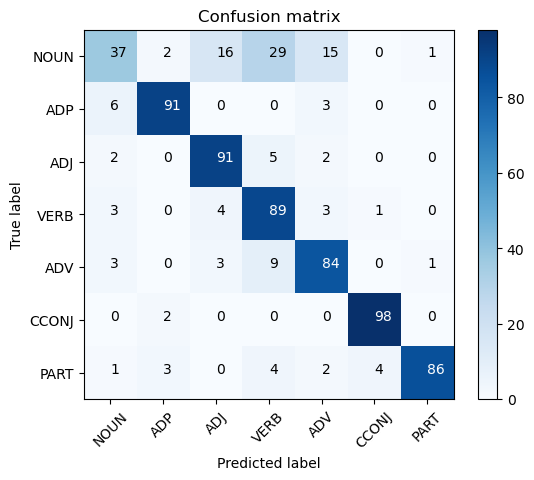

test set:
Confusion matrix, without normalization


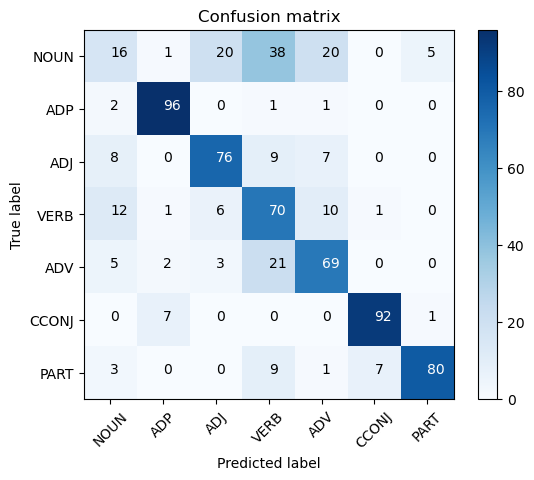

In [114]:
print("accuracy on train set:")
print(pipe.score(larrDC,larrLB))
print("accuracy on test set:")
print(pipe.score(tarrDC,tarrLB))

print("train set:")
confusion_matrix(pipe,larrDC,larrLB,class_names = Classes,normalize = False,shrink = 1)
print("test set:")
confusion_matrix(pipe,tarrDC,tarrLB,class_names = Classes,normalize = False,shrink = 1)

## Бутстрап и Бэггинг

In [24]:
def bootstrap(data_X_,data_L_,num_sel,sel_size = None):
    #по умолчанию бьет выборку на равные части (случайно выбирая элементы с повторением)
    #sel size в пределах от 0 до 1 задает размер частей относительно общего размера выборки
    #sel size больше 1 задает абсолютный размер частей
    data_X,data_L = skl.utils.shuffle(data_X_,data_L_)
    if(sel_size == None):
        sel_size = int(len(data_X) / num_sel)
    if(sel_size <= 1):
        sel_size = int(sel_size*len(data_X))
        
    mod_base = [[data_X[i],data_L[i]] for i in range(len(data_X))]
    
    all_sel = []
    for k in range(num_sel):
        cur_sel = []
        for i in range(sel_size):
            cur_sel.append(random.choice(mod_base))
        all_sel.append(cur_sel)
        
    return np.array(all_sel,dtype = object)

In [25]:
def unique_bootstrap(data_X_,data_L_,num_sel,sel_size = None):
    #то же, что и bootstrap, только без повторений в выборках
    data_X,data_L = skl.utils.shuffle(data_X_,data_L_)
    if(sel_size == None):
        sel_size = int(len(data_X) / num_sel)
    if(sel_size <= 1):
        sel_size = int(sel_size*len(data_X))
        
    mod_base = [[data_X[i],data_L[i]] for i in range(len(data_X))]
    
    all_sel = []
    for k in range(num_sel):
        cur_sel = []
        ind_taken = []
        for i in range(sel_size):
            cur = int(random.random()*len(mod_base))
            while(cur in ind_taken):
                cur = int(random.random()*len(mod_base))
            cur_sel.append(mod_base[cur])
            ind_taken.append(cur)
        all_sel.append(cur_sel)
        
    return np.array(all_sel,dtype = object)

Базовые алгоритмы однотипны, каждый обучается на своей подвыборке, подвыборки собираются с повторениями. При предсказании класса осуществляется голосование: за какой класс проголосует большинство алгоритмов, к тому объект иотносится

In [46]:
class bagging(skl.base.ClassifierMixin):
     
    def __init__(self,model_exmpl,model_count,soft_voting = False, sel_size = None):
        self.models = []
        for i in range(model_count):
            self.models.append(copy.deepcopy(model_exmpl))
            if(soft_voting):
                self.models[i].set_return_probability(True)
            
        self.spl_cnt = model_count
        self.soft_voting = soft_voting
        self.sel_size = sel_size
        
    def fit(self,data,labels,verbal = False):
        self.class_cnt = np.unique(labels)
        splits = bootstrap(data,labels,self.spl_cnt,self.sel_size)
        for i in range(self.spl_cnt):
            self.models[i].fit(splits[i,:,0],splits[i,:,1])
    
    def predict(self,data):
        class_score = np.zeros_like(self.class_cnt)
        
        if(self.soft_voting):
            for i in self.models:
                pred = i.predict([data])
                class_score[pred[0]] += pred[1]
        else:
            for i in self.models:
                pred = i.predict([data])
                class_score[pred] += 1
                
        return np.argmax(class_score)
    
    def accuracy(self,data,labels,verbal = False):
        correct = 0
        overall = 0
        sep_acc = []
        for mod in self.models:
            sep_acc.append(mod.score(data,labels))
        
        for i in range(len(data)):
            overall += 1
            cl = self.predict(data[i])
            if(cl == labels[i]):
                correct += 1            
            if(verbal):
                print(pred)
                print(cl)
            res = [correct/overall]
            for i in sep_acc:
                res.append(i)
        return np.array(res)
        
    def score(self,data,labels,verbal = False):
        return self.accuracy(data,labels,verbal = verbal)

Алгоритм поддерживает мягкое голосование. Для его использования необходимо, чтобы базовый алгоритм поддерживал метод set_return_probability и возвращать вероятность, с которой объект действительно относится к определенному классу в формате [class,probability]

Таким образом были можифицированы два основных используемых в данной задаче алгоритма - наивный байесовский и KNN.

#### Тесты с наивным байесовским алгоритмом:

In [185]:
bg = bagging(Naive_Bayes(),20,sel_size = 300)
pipe = Pipeline([('transformer',transform()),('classifier',bg)])
CrossValidataion = RCV([larrDC,larrLB],[tarrDC,tarrLB],pipe = pipe)
arr = CrossValidataion.validate(i = 20)
arr.mean(axis = 0)

array([0.6270357142857141, 0.5397857142857142, 0.5369642857142857,
       0.5367857142857142, 0.5259285714285713, 0.526892857142857,
       0.5277142857142856, 0.5271785714285715, 0.5385, 0.5282142857142856,
       0.5305714285714285, 0.5283214285714285, 0.54025,
       0.5387857142857143, 0.55025, 0.5349285714285714,
       0.5379642857142859, 0.5432857142857143, 0.5468571428571428,
       0.54225, 0.5333214285714286], dtype=object)

In [186]:
bg = bagging(Naive_Bayes(),20,soft_voting = True)
pipe = Pipeline([('transformer',transform()),('classifier',bg)])
CrossValidataion = RCV([larrDC,larrLB],[tarrDC,tarrLB],pipe = pipe)
arr = CrossValidataion.validate(i = 100)
arr.mean(axis = 0)

array([0.6989214285714291, 0.5291714285714285, 0.5395285714285712,
       0.5352285714285716, 0.5398357142857141, 0.5349857142857142,
       0.5410714285714286, 0.5321785714285712, 0.5460071428571429,
       0.5421571428571427, 0.5366357142857141, 0.5327785714285715,
       0.5375142857142857, 0.5339857142857142, 0.5365642857142856,
       0.5273357142857145, 0.5326428571428571, 0.5321714285714286,
       0.5365428571428572, 0.5403642857142859, 0.5335499999999999],
      dtype=object)

In [33]:
bg = bagging(Naive_Bayes(),20,soft_voting = True,sel_size = 0.5)
pipe = Pipeline([('transformer',transform()),('classifier',bg)])
CrossValidataion = RCV([larrDC,larrLB],[tarrDC,tarrLB],pipe = pipe)
arr = CrossValidataion.validate(i = 100)
arr.mean(axis = 0)

array([0.7002714285714284, 0.6487571428571427, 0.6452857142857146,
       0.6452999999999999, 0.6420285714285717, 0.6408857142857143,
       0.6426285714285714, 0.6448999999999999, 0.6453714285714288,
       0.6483428571428571, 0.6453714285714287, 0.6442857142857144,
       0.6387428571428572, 0.6428857142857143, 0.6467714285714287,
       0.6430571428571428, 0.6444285714285714, 0.6421000000000001,
       0.641442857142857, 0.6388714285714284, 0.6414714285714284],
      dtype=object)

Наблюдается сущесвенный рост точности при использовании мягкого голосования.  
Также, видно, что, чем больше размер подвыборок при бутстрапе, тем выше точность базовых алгоритмов и, как следствие, всего ансамбля

In [42]:
bg = bagging(Naive_Bayes(),20,soft_voting = True,sel_size = 1)
pipe = Pipeline([('transformer',transform()),('classifier',bg)])
CrossValidataion = RCV([larrDC,larrLB],[tarrDC,tarrLB],pipe = pipe)
arr = CrossValidataion.validate(i = 100)
arr.mean(axis = 0)

array([0.7038857142857143, 0.6703428571428574, 0.6723571428571431,
       0.6689857142857142, 0.6720714285714284, 0.6747, 0.6667857142857142,
       0.6682857142857144, 0.6694, 0.6705714285714284, 0.6663142857142859,
       0.6667857142857139, 0.6662571428571431, 0.6718571428571427,
       0.6704000000000001, 0.6698714285714287, 0.6703857142857141,
       0.6699142857142859, 0.6693714285714285, 0.6682285714285715,
       0.6700571428571429], dtype=object)

#### Тесты с KNN:

Для начала попробуем использовать k = 1: очевидно, что тогда мягкое голосование не даст прироста точности, но сама точность должна быть высока.

In [35]:
bg = bagging(KNN(k = 1),20,soft_voting = False,sel_size = 0.5)
pipe = Pipeline([('transformer',transform()),('classifier',bg)])
CrossValidataion = RCV([larrDC,larrLB],[tarrDC,tarrLB],pipe = pipe)
arr = CrossValidataion.validate(i = 20)
arr.mean(axis = 0)

array([0.8210714285714287, 0.7486428571428572, 0.7502857142857142,
       0.729642857142857, 0.7516428571428572, 0.7460714285714285,
       0.7440714285714287, 0.7445714285714286, 0.7517142857142858,
       0.7569285714285714, 0.7485714285714286, 0.7449285714285716,
       0.7353571428571428, 0.7461428571428572, 0.7602857142857142,
       0.7486428571428572, 0.7500000000000001, 0.7567142857142858,
       0.7340714285714285, 0.7572142857142856, 0.7458571428571428],
      dtype=object)

In [36]:
bg = bagging(KNN(k = 1),20,soft_voting = True,sel_size = 0.5)
pipe = Pipeline([('transformer',transform()),('classifier',bg)])
CrossValidataion = RCV([larrDC,larrLB],[tarrDC,tarrLB],pipe = pipe)
arr = CrossValidataion.validate(i = 20)
arr.mean(axis = 0)

array([0.8227142857142857, 0.7518571428571429, 0.7464285714285716, 0.75,
       0.7404999999999999, 0.7397857142857143, 0.7442857142857143,
       0.7329285714285716, 0.7577142857142858, 0.7434285714285713,
       0.7477857142857143, 0.7592142857142858, 0.749642857142857,
       0.7374999999999999, 0.7544285714285713, 0.7517857142857143, 0.741,
       0.7549285714285714, 0.7444999999999998, 0.7535000000000001,
       0.7572857142857141], dtype=object)

Действительно, разница между алгоритмом с мягким голосованием и без него отсутствует.  
Теперь посмотрим, что будет, если использовать k = 3

In [37]:
bg = bagging(KNN(k = 3),20,soft_voting = False,sel_size = 0.5)
pipe = Pipeline([('transformer',transform()),('classifier',bg)])
CrossValidataion = RCV([larrDC,larrLB],[tarrDC,tarrLB],pipe = pipe)
arr = CrossValidataion.validate(i = 20)
arr.mean(axis = 0)

array([0.7420000000000002, 0.6723571428571429, 0.6833571428571429,
       0.6742142857142857, 0.6717142857142857, 0.6534285714285712,
       0.6737857142857144, 0.6737857142857142, 0.6646428571428571,
       0.6671428571428571, 0.6677857142857142, 0.667, 0.6639999999999999,
       0.6678571428571429, 0.6672142857142858, 0.6734285714285715,
       0.6694285714285715, 0.6657142857142857, 0.6692142857142855,
       0.6682142857142858, 0.672], dtype=object)

In [38]:
bg = bagging(KNN(k = 3),20,soft_voting = True,sel_size = 0.5)
pipe = Pipeline([('transformer',transform()),('classifier',bg)])
CrossValidataion = RCV([larrDC,larrLB],[tarrDC,tarrLB],pipe = pipe)
arr = CrossValidataion.validate(i = 20)
arr.mean(axis = 0)

array([0.750642857142857, 0.6752142857142858, 0.6698571428571429,
       0.6712142857142858, 0.6702142857142857, 0.6742857142857143, 0.6695,
       0.6719285714285715, 0.68, 0.6757857142857143, 0.6729999999999999,
       0.6763571428571428, 0.6705000000000001, 0.6676428571428572,
       0.6528571428571428, 0.6705714285714286, 0.677, 0.6680000000000003,
       0.6639999999999999, 0.6742857142857144, 0.6663571428571429],
      dtype=object)

Наблюдается несущественный прирост точности при мягком голосовании, но общая точность гораздо ниже, чем с k = 1

In [156]:
bg = bagging(KNN(k = 1),20,soft_voting = False,sel_size = 0.5)
pipe = Pipeline([('transformer',transform()),('classifier',bg)])
ft = pipe.fit(larrDC,larrLB)

accuracy on train set:
[0.91142857 0.81571429 0.82142857 0.81285714 0.80714286 0.82571429
 0.83       0.82714286 0.81571429 0.82571429 0.82       0.78571429
 0.83142857 0.82285714 0.82285714 0.80714286 0.79142857 0.84
 0.82       0.82142857 0.82714286]
accuracy on test set:
[0.74       0.70857143 0.69428571 0.7        0.67285714 0.69428571
 0.71571429 0.69857143 0.69714286 0.69428571 0.70571429 0.67571429
 0.71142857 0.70571429 0.68428571 0.66428571 0.67857143 0.70571429
 0.70714286 0.67571429 0.69714286]
train set:
Confusion matrix, without normalization


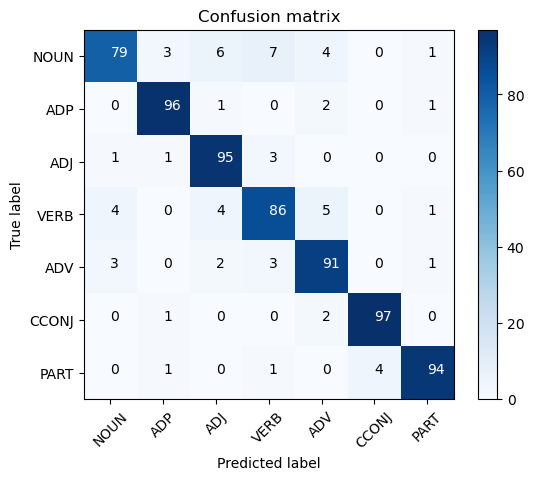

test set:
Confusion matrix, without normalization


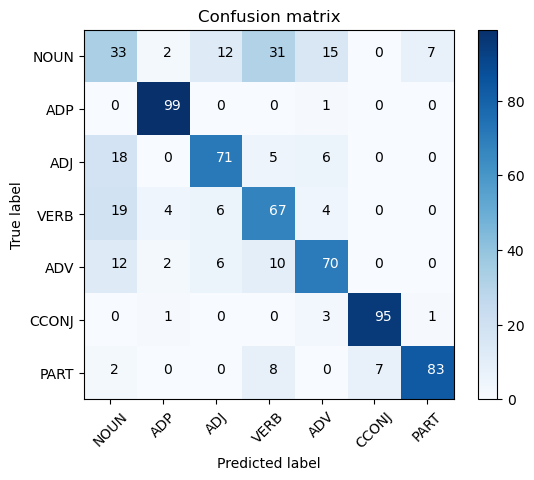

In [157]:
print("accuracy on train set:")
print(pipe.score(larrDC,larrLB))
print("accuracy on test set:")
print(pipe.score(tarrDC,tarrLB))

print("train set:")
confusion_matrix(pipe,larrDC,larrLB,class_names = Classes,normalize = False,shrink = 1)
print("test set:")
confusion_matrix(pipe,tarrDC,tarrLB,class_names = Classes,normalize = False,shrink = 1)

## Пастинг

(Пастинг - это как Бэггинг, но в подвыборках нет повторений)  
Для реализации этого алгоритма используется функция unique_bootstrap, которая реализует биение на подвыборки без повторений

In [185]:
class pasting(skl.base.ClassifierMixin):
       
    def __init__(self,model_exmpl,model_count,soft_voting = False, sel_size = None):
        self.models = []
        for i in range(model_count):
            self.models.append(copy.deepcopy(model_exmpl))
            if(soft_voting):
                self.models[i].set_return_probability(True)
            
        self.spl_cnt = model_count
        self.soft_voting = soft_voting
        self.sel_size = sel_size
        
    def fit(self,data,labels,verbal = False):
        self.class_cnt = np.unique(labels)
        splits = unique_bootstrap(data,labels,self.spl_cnt,self.sel_size)
        for i in range(self.spl_cnt):
            self.models[i].fit(splits[i,:,0],splits[i,:,1])
    
    def predict(self,data):
        class_score = np.zeros_like(self.class_cnt)
        
        if(self.soft_voting):
            for i in self.models:
                pred = i.predict(data)
                class_score[pred[0]] += pred[1]
        else:
            for i in self.models:
                pred = i.predict(data)
                class_score[pred] += 1
                
        return np.argmax(class_score)
    
    def accuracy(self,data,labels,verbal = False):
        correct = 0
        overall = 0
        sep_acc = []
        for mod in self.models:
            sep_acc.append(mod.score(data,labels))
        
        for i in range(len(data)):
            overall += 1
            cl = self.predict([data[i]])
            if(cl == labels[i]):
                correct += 1            
            if(verbal):
                print(pred)
                print(cl)
            res = [correct/overall]
            for i in sep_acc:
                res.append(i)
        return np.array(res)
        
    def score(self,data,labels,verbal = False):
        return self.accuracy(data,labels,verbal = verbal)

#### Тесты с наивным байесовским алгоритмом 

In [250]:
pt = pasting(Naive_Bayes(),20)
pipe = Pipeline([('transformer',transform()),('classifier',pt)])
CrossValidataion = RCV([larrDC,larrLB],[tarrDC,tarrLB],pipe = pipe)
arr = CrossValidataion.validate(i = 20)
arr.mean(axis = 0)

array([0.6186071428571428, 0.5438214285714285, 0.5354642857142856,
       0.5195714285714286, 0.5346785714285713, 0.5289285714285714,
       0.5117499999999999, 0.5288214285714288, 0.5246071428571429,
       0.5190357142857144, 0.534, 0.5230714285714286, 0.5249999999999999,
       0.5424999999999999, 0.5183571428571428, 0.5438571428571428,
       0.5152857142857141, 0.5293214285714285, 0.542, 0.5425714285714285,
       0.5141428571428571], dtype=object)

In [251]:
pt = pasting(Naive_Bayes(),20,soft_voting = True)
pipe = Pipeline([('transformer',transform()),('classifier',pt)])
CrossValidataion = RCV([larrDC,larrLB],[tarrDC,tarrLB],pipe = pipe)
arr = CrossValidataion.validate(i = 20)
arr.mean(axis = 0)

array([0.6779285714285714, 0.5249642857142857, 0.5294642857142857,
       0.5269285714285715, 0.5107857142857142, 0.5261785714285716,
       0.5345714285714287, 0.5308928571428572, 0.5523571428571429,
       0.5224285714285714, 0.5164642857142857, 0.5309285714285714,
       0.5244285714285714, 0.5315000000000001, 0.5264285714285715,
       0.5340357142857142, 0.532607142857143, 0.5363571428571428,
       0.5246785714285713, 0.5401428571428571, 0.5117499999999999],
      dtype=object)

Видим, что результат при малом размере подвыборки не сильно отличается от бэггинга, мягкое голосование все так же дает ощутимый эффект

In [45]:
pt = pasting(Naive_Bayes(),20,soft_voting = True,sel_size = 1)
pipe = Pipeline([('transformer',transform()),('classifier',pt)])
CrossValidataion = RCV([larrDC,larrLB],[tarrDC,tarrLB],pipe = pipe)
arr = CrossValidataion.validate(i = 20)
arr.mean(axis = 0)

array([0.6990714285714283, 0.6990714285714283, 0.6990714285714283,
       0.6990714285714283, 0.6990714285714283, 0.6990714285714283,
       0.6990714285714283, 0.6990714285714283, 0.6990714285714283,
       0.6990714285714283, 0.6990714285714283, 0.6990714285714283,
       0.6990714285714283, 0.6990714285714283, 0.6990714285714283,
       0.6990714285714283, 0.6990714285714283, 0.6990714285714283,
       0.6990714285714283, 0.6990714285714283, 0.6990714285714283],
      dtype=object)

Интересно, что при размере подвыборок, равном размеру оригинальной выборки все базвоые алгоритмы становятся идентичны друг другу и ансамбль вырождается. С бэгингом такого не происходит из-за того, что тот допускает повторения в выборках, и, даже при одинаковом размере подвыборок и оригинальной выборки есть небольшой прирост точности ансамбля в сравнении с базовыми алгоритмами. 

In [191]:
bg = pasting(Naive_Bayes(),20,soft_voting = False,sel_size = 0.5)
pipe = Pipeline([('transformer',transform()),('classifier',bg)])
ft = pipe.fit(larrDC,larrLB)

print("accuracy on train set:")
print(pipe.score(larrDC,larrLB))
print("accuracy on test set:")
print(pipe.score(tarrDC,tarrLB))

accuracy on train set:
[0.72857143 0.70142857 0.71714286 0.67714286 0.73142857 0.69285714
 0.71714286 0.69       0.72285714 0.71       0.7        0.67571429
 0.71428571 0.72285714 0.70285714 0.65285714 0.69428571 0.68428571
 0.69571429 0.7        0.70857143]
accuracy on test set:
[0.66428571 0.63142857 0.65428571 0.62857143 0.64714286 0.62571429
 0.64714286 0.63428571 0.63285714 0.64142857 0.60428571 0.63857143
 0.65714286 0.64285714 0.66428571 0.58428571 0.63285714 0.60571429
 0.65428571 0.66285714 0.63285714]


train set:
Confusion matrix, without normalization


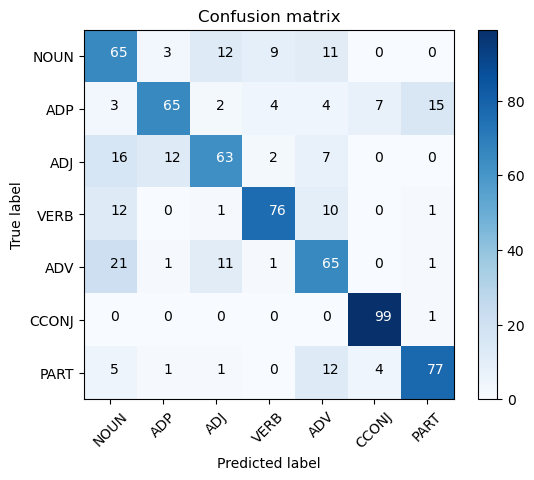

test set:
Confusion matrix, without normalization


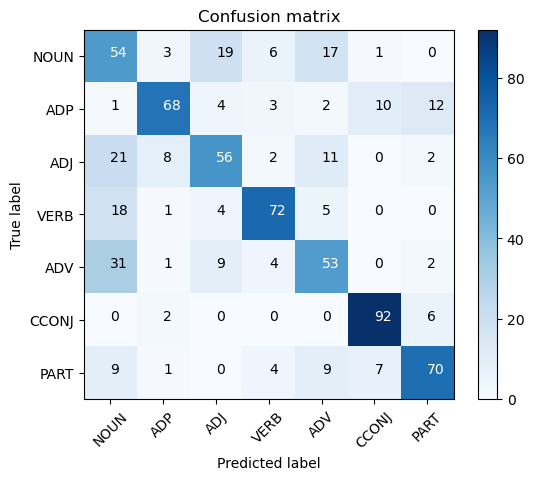

In [192]:
print("train set:")
confusion_matrix(pipe,larrDC,larrLB,class_names = Classes,normalize = False,shrink = 1)
print("test set:")
confusion_matrix(pipe,tarrDC,tarrLB,class_names = Classes,normalize = False,shrink = 1)

## Бустинг

Обучать алгоритмы по очереди, тем элементам, которые были классифицированы неверно, увеличивать вес. При предсказании учитывать результат каждого классификатора в завичимости от его точности.

In [22]:
class boosting(skl.base.ClassifierMixin):
    
    def __init__(self,model_exmpl,model_count):
        self.models = []
        for i in range(model_count):
            self.models.append(copy.deepcopy(model_exmpl))
            
        self.mod_cnt = model_count
        
    def fit(self,data_,labels_,verbal = False):
        data = np.array(copy.deepcopy(data_))
        labels = np.array(copy.deepcopy(labels_))
        wts = np.ones_like(labels)
        self.cl_cnt = len(np.unique(labels))
        
        err_X = None
        err_L = None
        self.wts = []
        num = 0
        for alg in self.models:
            num+=1
            
            errors_X = []
            errors_L = []
            
            alg.fit(data,labels,wts = wts)
            ln = len(data)
                
            for i in range(ln):
                if (alg.predict([data[i]]) != labels[i]):
                    errors_X.append(copy.deepcopy(data[i]))
                    errors_L.append(copy.deepcopy(labels[i]))
                 
            err_part = 1 - alg.score(data_,labels_)
                        
            if(verbal):
                print(len(err_X))
                print(len(data_))
                print("errors: {} ovl: {} err_part: {} trained on: {}".format(len(errors),ln,err_part,ln))
            
            cur_w = 0.5*np.log((1 - err_part)/err_part)
            if(err_part < 0.3):
                cur_w += 1
            
            #print("{} \t >{}".format(cur_w, 1 - err_part))
            
            self.wts.append(cur_w)
            
            for i in range(ln):
                if (alg.predict([data[i]]) != labels[i]):
                    wts[i] += num
            
    def predict(self,data):
        pred = np.ones(self.cl_cnt)
        for j in range(len(self.models)):
            pred[self.models[j].predict(data)] += self.wts[j]*100

        cl = np.argmax(pred)
        return cl
        
    def accuracy(self,data,labels,verbal = False):
        correct = 0
        overall = 0
        sep_acc = []
        for mod in self.models:
            sep_acc.append(mod.score(data,labels))
        
        for i in range(len(data)):
            overall += 1
            pred = np.ones_like(np.unique(labels))
            for j in range(len(self.models)):
                pred[self.models[j].predict([data[i]])] += self.wts[j]*100
                
            cl = np.argmax(pred)
            if(cl == labels[i]):
                correct += 1
            if(verbal):
                print(pred)
                print("{} {}".format(cl,labels[i]))
            
            res = [correct/overall]
            for i in sep_acc:
                res.append(i)
        return np.array(res)
        
    def score(self,data,labels,verbal = False):
        return self.accuracy(data,labels,verbal = verbal)

In [405]:
bt = boosting(Naive_Bayes(),100)
pipe = Pipeline([('transformer',transform()),('classifier',bt)])
pipe.fit(larrDC,larrLB)
print(pipe.score(larrDC,larrLB))
print(pipe.score(tarrDC,tarrLB))

[0.72190476 0.71333333 0.7        0.69857143 0.53809524 0.52047619
 0.53428571 0.68       0.64761905 0.70333333 0.62952381 0.65238095
 0.59571429 0.55       0.70666667 0.72190476 0.71285714 0.69190476
 0.59857143 0.65619048 0.6652381  0.58761905 0.71095238 0.71761905
 0.68333333 0.72857143 0.65285714 0.70142857 0.70666667 0.70571429
 0.6352381  0.57428571 0.69571429 0.7152381  0.64190476 0.72571429
 0.7147619  0.72238095 0.69095238 0.71380952 0.70380952 0.66238095
 0.69666667 0.56380952 0.68333333 0.64333333 0.71190476 0.69095238
 0.69666667 0.71285714 0.69047619 0.65761905 0.71047619 0.71857143
 0.58904762 0.73952381 0.66666667 0.71380952 0.70047619 0.7
 0.58857143 0.66809524 0.71428571 0.70380952 0.60952381 0.7247619
 0.68285714 0.69952381 0.73428571 0.67380952 0.71190476 0.66857143
 0.73190476 0.6952381  0.68571429 0.70285714 0.71380952 0.69285714
 0.49952381 0.69142857 0.70571429 0.7152381  0.68333333 0.70333333
 0.72428571 0.70952381 0.67809524 0.66714286 0.71333333 0.69333333
 0.

In [25]:
bt = boosting(Naive_Bayes(),20)
pipe = Pipeline([('transformer',transform()),('classifier',bt)])
CrossValidataion = RCV([larrDC,larrLB],[tarrDC,tarrLB],pipe = pipe)
arr = CrossValidataion.validate(i = 20)
arr.mean(axis = 0)

array([0.7023571428571429, 0.684657142857143, 0.6885714285714285,
       0.6500571428571429, 0.5150857142857143, 0.4629142857142857,
       0.5947428571428572, 0.6487714285714287, 0.6263714285714286,
       0.6210142857142857, 0.6255428571428571, 0.5977571428571429,
       0.6219285714285715, 0.6339857142857144, 0.6382571428571429,
       0.6509714285714286, 0.6401, 0.6417714285714285, 0.6445428571428571,
       0.6289285714285713, 0.6495857142857142], dtype=object)

train set:
Confusion matrix, without normalization


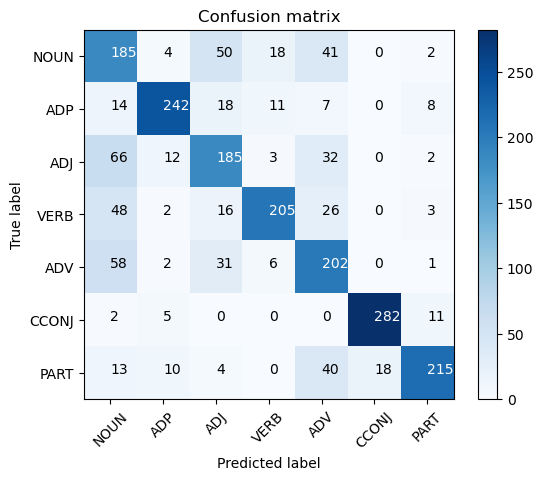

test set:
Confusion matrix, without normalization


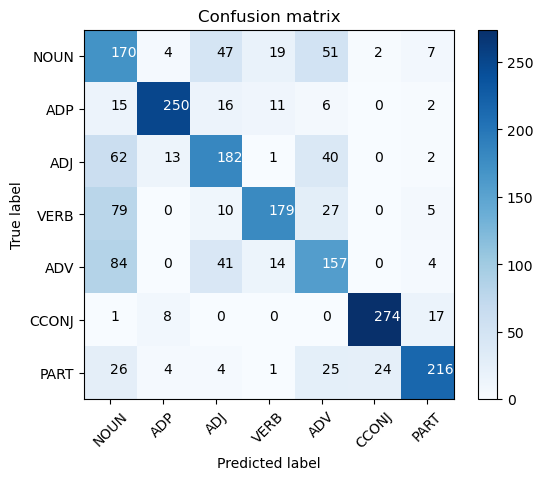

In [406]:
print("train set:")
confusion_matrix(pipe,larrDC,larrLB,class_names = Classes,normalize = False,shrink = 1)
print("test set:")
confusion_matrix(pipe,tarrDC,tarrLB,class_names = Classes,normalize = False,shrink = 1)

In [408]:
bt = boosting(Naive_Bayes(),5)
pipe = Pipeline([('transformer',transform()),('classifier',bt)])
CrossValidataion = RCV([larrDC,larrLB],[tarrDC,tarrLB],pipe = pipe)
arr = CrossValidataion.validate(i = 20)

In [409]:
arr.mean(axis = 0)

array([0.6980000000000001, 0.6894285714285713, 0.6908809523809524,
       0.6785238095238095, 0.5552380952380953, 0.4682380952380953],
      dtype=object)

## Решающее дерево

In [94]:
def entropy(n_cl,arr):
    c_cl = np.zeros(n_cl)
    for a in arr:
        c_cl[int(a)] += 1
    h = 0
    for a in c_cl:
        if(a != 0):
            h -= (a/len(arr)) * (np.log(a/len(arr)))
    
    return h

def split_by_feat(array,arr_lb,feat_n,split_val):
    lhs = []
    rhs = []
    lhs_lb = []
    rhs_lb = []
    for i in range(len(array)):
        elm = array[i]
        if(elm[feat_n] >= split_val):
            rhs.append(array[i])
            rhs_lb.append(arr_lb[i])
        else:
            lhs.append(array[i])
            lhs_lb.append(arr_lb[i])
    
    return np.array(lhs,dtype = object),np.array(lhs_lb,dtype = object),np.array(rhs,dtype = object),np.array(rhs_lb,dtype = object)

def domination(array,cl_num,required_part = 1,verbal = False):
    index = np.zeros(cl_num)
    for elm in array:
        index[elm] += 1
    
    amg = np.argmax(index)
    
    if(verbal):
        print("({} {} ({}))".format(int(index[amg]), int(np.sum(index)), 
                             index[amg]/np.sum(index)))
    
    if(index[amg]/np.sum(index) > required_part):
        return amg
    else:
        return None

def find_optimal_split(data,labels,depth,termination_depth = 10,verbal = False, dropout = 0):
    
    if(verbal):
        print("{}({}) | {}".format(depth,termination_depth,len(labels)))
    
    if(depth > termination_depth):
        return domination(labels,7,required_part = 0,verbal = verbal)
    
    dm = domination(labels,7,required_part = 1,verbal = verbal)
    if(dm != None):
        return dm
    
    if(len(labels) == 0):
        return 0
    
    if(len(data.shape) == 1):
        feats_cnt = 1
    else:
        feats_cnt = data.shape[1]
    class_cnt = len(np.unique(labels))
    
    class_cnt = (np.max(labels)) + 1
    
    feats_vocab = []
    for feat_ind in range(feats_cnt):
        cur_feat = []
        for elm in data:
            if(elm[feat_ind] not in cur_feat):
                cur_feat.append(elm[feat_ind])
        feats_vocab.append(np.sort(cur_feat))
    
    optimal_split_ind = -5,-5
    optimal_split_entropy = np.inf
    
    features_to_pass = int((1 - dropout)*len(feats_vocab))
    if(features_to_pass == 0):
        features_to_pass = 1
    
    feat_selection = np.arange(len(feats_vocab))
    feat_selected = []
    while(len(feat_selected) < features_to_pass):
        cf = random.choice(feat_selection)
        if(not cf in feat_selected):
            feat_selected.append(cf)
    for feat_ind in feat_selected:

        feat = feats_vocab[feat_ind]
                       
        for val_ind in range(len(feat)):
            if(val_ind == 0):
                continue
                
            if(verbal):
                print(" --|{}|--".format(len(feat)))
            
            splits = split_by_feat(data,labels,feat_ind,feat[val_ind])
            
            cur_split_entropy = entropy(class_cnt,splits[1]) + entropy(class_cnt,splits[3])
            if(cur_split_entropy < optimal_split_entropy):
                optimal_split_ind = feat_ind,feat[val_ind]
                
                optimal_split_entropy = cur_split_entropy

    if(optimal_split_entropy == np.inf):
        return domination(labels,7,required_part = 0,verbal = verbal) 
    
    optimal_split = split_by_feat(data,labels,optimal_split_ind[0],optimal_split_ind[1])
    
    if(verbal):
        print("|| {}  - {} ||".format(optimal_split[1],optimal_split[3]))
        print("| {} |".format(optimal_split_ind))
        print("___________")
    
    spl_nxt_1 = find_optimal_split(optimal_split[0],optimal_split[1],depth + 1,
                                   termination_depth = termination_depth,
                                   verbal = verbal,dropout = dropout)
    spl_nxt_2 = find_optimal_split(optimal_split[2],optimal_split[3],depth + 1,
                                   termination_depth = termination_depth,
                                   verbal = verbal,dropout = dropout)
    return (optimal_split_ind, spl_nxt_1,spl_nxt_2)
        

In [95]:
class solver_tree(skl.base.ClassifierMixin):
    def __init__(self,termination_depth = 50,verbal = False,dropout = 0):
        self.termination_depth = termination_depth
        self.verbal = verbal
        self.dropout = dropout
    
    def score(self,data,labels):
        overall = 0
        correct = 0
        for i in range(len(data)):
            overall += 1
            if(self.predict([data[i]]) == labels[i]):
                correct += 1
        return correct/overall
    
    def predict(self,elm):
        data = elm[0] 
        solver = copy.deepcopy(self.solver)
        if(self.verbal):
            print(data)
        while np.shape(solver) != ():
            if(self.verbal):
                print(solver[0])
            if(data[solver[0][0]] >= solver[0][1]):
                if(self.verbal):
                    print(" --> {}".format(solver[2]))
                if(np.shape(solver[2]) == ()):
                    return solver[2]
                else:
                    solver = copy.deepcopy(solver[2])
            else:
                if(self.verbal):
                    print(" --> {}".format(solver[1]))
                if(np.shape(solver[1]) == ()):
                    return solver[1]
                else:
                    solver = copy.deepcopy(solver[1])
    
    def fit(self,data_,labels_,verbal = False):
        data = np.array(copy.deepcopy(data_),dtype= object)
        labels = np.array(copy.deepcopy(labels_),dtype= object)
        pairs = np.array([[data[i],labels[i]] 
                          for i in range(len(labels))],dtype = object)
        
        if(len(data.shape) == 1):
            feats_cnt = 1
        else:
            feats_cnt = data.shape[1]
        class_cnt = len(np.unique(labels))
        
        feats_vocab = []
        for feat_ind in range(feats_cnt):
            cur_feat = []
            for elm in data:
                if(elm[feat_ind] not in cur_feat):
                    cur_feat.append(elm[feat_ind])
            feats_vocab.append(np.sort(cur_feat))
        
        optimal_split_ind = -1,-1
        optimal_split_entropy = np.inf
        
        spl_res = find_optimal_split(data,labels,0,termination_depth = 
                                     self.termination_depth,
                                     verbal = self.verbal,dropout = self.dropout)
        
        if(self.verbal):
            print(spl_res)
        
        self.solver = spl_res

In [101]:
larrLB,larrDC,tarrLB,tarrDC = create_dataset(ClLen = 200)

#### Кросс-валидация решающего дерева:

In [102]:
st = solver_tree(termination_depth = 50)
pipe = Pipeline([('transformer',transform()),('classifier',st)])
CrossValidataion = RCV([larrDC,larrLB],[tarrDC,tarrLB],pipe = pipe)
arr = CrossValidataion.validate(i = 10)

In [103]:
print("accuracy:")
print(arr.mean(axis = 0))

accuracy:
0.8426428571428571


#### Построение зависимости [предельно допустимая глубина / точность]

In [40]:
arr_res = []
for i in range(1,50,5):
    st = solver_tree(termination_depth = i)
    pipe = Pipeline([('transformer',transform()),('classifier',st)])
    pipe.fit(larrDC,larrLB)
    
    arr_res.append([i,pipe.score(larrDC,larrLB),pipe.score(tarrDC,tarrLB)])
    
for i in range(60,100,10):
    st = solver_tree(termination_depth = i)
    pipe = Pipeline([('transformer',transform()),('classifier',st)])
    pipe.fit(larrDC,larrLB)
    
    arr_res.append([i,pipe.score(larrDC,larrLB),pipe.score(tarrDC,tarrLB)])
    
arr_res = np.array(arr_res)

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


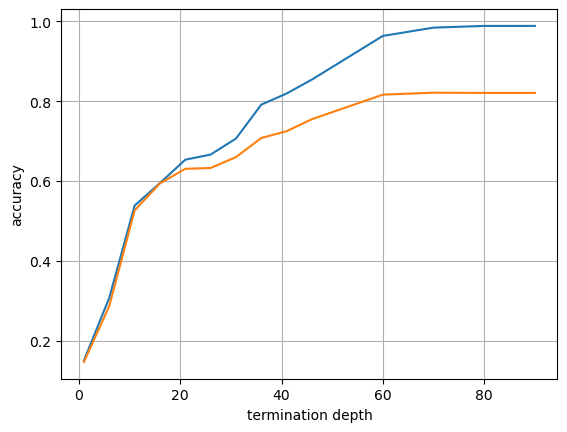

In [41]:
pylab.grid()

pylab.xlabel('termination depth')
pylab.ylabel('accuracy')
pylab.plot(arr_res[:,0],arr_res[:,1])
pylab.plot(arr_res[:,0],arr_res[:,2])
pylab.show()

## Случайный лес

In [98]:
class random_forest(skl.base.ClassifierMixin):
    def __init__(self,trees_count,max_depth = 50,sel_size = None,dropout = 0.5):
        self.sel_size = sel_size
        self.models = []
        for i in range(trees_count):
            self.models.append(solver_tree(termination_depth = max_depth,dropout = dropout))
            
        self.mod_cnt = trees_count
    
    def fit(self,data,labels):
        selections = bootstrap(data,labels,num_sel = self.mod_cnt,sel_size = self.sel_size)
        
        for i in range(self.mod_cnt):
            self.models[i].fit(selections[i,:,0],selections[i,:,1])
    
    def predict(self,data):
        pred = []
        for k in self.models:
            pred.append(k.predict(data))
        uc = np.unique(pred, return_counts=True)
        cl = uc[0][np.argmax(uc[1])]
        return cl
    
    def accuracy(self,data,labels,verbal = False):
        correct = 0
        overall = 0
        sep_acc = []
        for mod in self.models:
            sep_acc.append(mod.score(data,labels))
        
        for i in range(len(data)):
            overall += 1
            pred = []
            for k in self.models:
                pred.append(k.predict([data[i]]))
            uc = np.unique(pred, return_counts=True)
            cl = uc[0][np.argmax(uc[1])]
            if(cl == labels[i]):
                correct += 1            
            if(verbal):
                print(pred)
                print(cl)
            res = [correct/overall]
            for i in sep_acc:
                res.append(i)
        return np.array(res)
        
    def score(self,data,labels,verbal = False):
        return self.accuracy(data,labels,verbal = verbal)

#### Матрица спутывания

In [88]:
rf = random_forest(trees_count = 10,max_depth = 40,sel_size = 300)
pipe = Pipeline([('transformer',transform()),('classifier',rf)])
pipe.fit(larrDC,larrLB)

print(pipe.score(larrDC,larrLB))
print(pipe.score(tarrDC,tarrLB))

[0.85857143 0.73       0.74071429 0.77071429 0.73785714 0.73642857
 0.72       0.75642857 0.75571429 0.76428571 0.76357143]
[0.785      0.65642857 0.66214286 0.70285714 0.71357143 0.65928571
 0.66       0.68285714 0.71428571 0.71785714 0.67714286]


train set:
Confusion matrix, without normalization


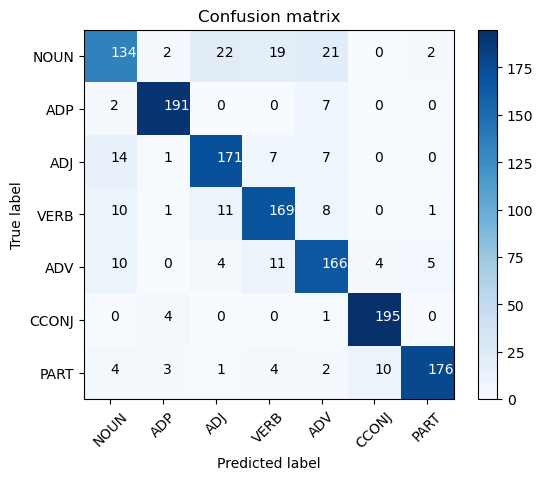

test set:
Confusion matrix, without normalization


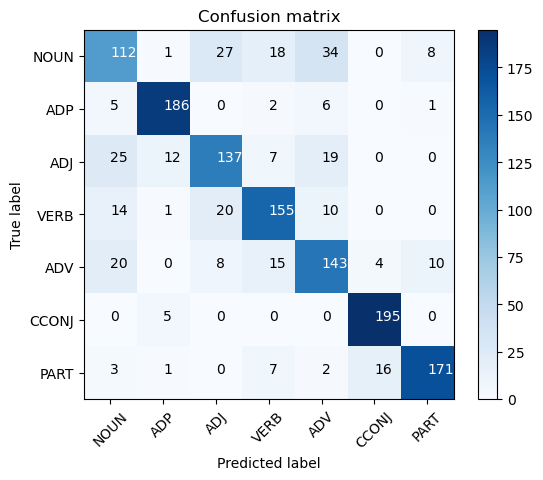

In [89]:
print("train set:")
confusion_matrix(pipe,larrDC,larrLB,class_names = Classes,normalize = False,shrink = 1)
print("test set:")
confusion_matrix(pipe,tarrDC,tarrLB,class_names = Classes,normalize = False,shrink = 1)

### Построение зависимостей [предельная глубина / точность] для случайного леса и для одного решающего дерева на выборках одинаковой длины:

In [104]:
arr_res = []
for i in range(1,50,5):
    rf = random_forest(trees_count = 10,max_depth = i,sel_size = 300)
    pipe = Pipeline([('transformer',transform()),('classifier',rf)])
    pipe.fit(larrDC,larrLB)
    
    arr_res.append([i,pipe.score(larrDC,larrLB),pipe.score(tarrDC,tarrLB)])

#### Случайный лес из 10 деревьев, каждое из которых обучно на выборке из 300 элементов, наразделении берется половина признаков

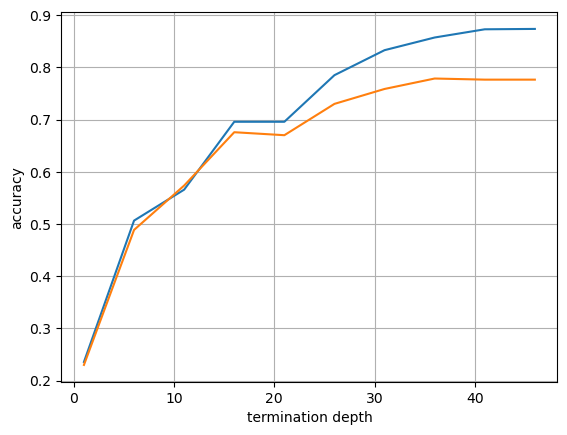

In [105]:
arr_res = np.array(arr_res,dtype = object)
res_arr = []
for i in arr_res:
    res_arr.append([i[0],i[1][0],i[2][0]])
res_arr = np.array(res_arr)

pylab.grid()

pylab.xlabel('termination depth')
pylab.ylabel('accuracy')
pylab.plot(res_arr[:,0],res_arr[:,1])
pylab.plot(res_arr[:,0],res_arr[:,2])
pylab.show()

In [67]:
sel = bootstrap(larrDC,larrLB,num_sel = 1,sel_size = 300)[0]
sel_X = sel[:,0]
sel_L = sel[:,1]
sel_t = bootstrap(larrDC,larrLB,num_sel = 1,sel_size = 300)[0]
sel_t_X = sel_t[:,0]
sel_t_L = sel_t[:,1]

In [68]:
arr_res = []
for i in range(1,50,5):
    st = solver_tree(termination_depth = i)
    pipe = Pipeline([('transformer',transform()),('classifier',st)])
    pipe.fit(sel_X,sel_L)
    
    arr_res.append([i,pipe.score(sel_X,sel_L),pipe.score(sel_t_X,sel_t_L)])
    
for i in range(60,100,10):
    st = solver_tree(termination_depth = i)
    pipe = Pipeline([('transformer',transform()),('classifier',st)])
    pipe.fit(sel_X,sel_L)
    
    arr_res.append([i,pipe.score(sel_X,sel_L),pipe.score(sel_t_X,sel_t_L)])
    
arr_res = np.array(arr_res)

#### Одно решабщее дерево, обученное на выборке из 300 элементов:

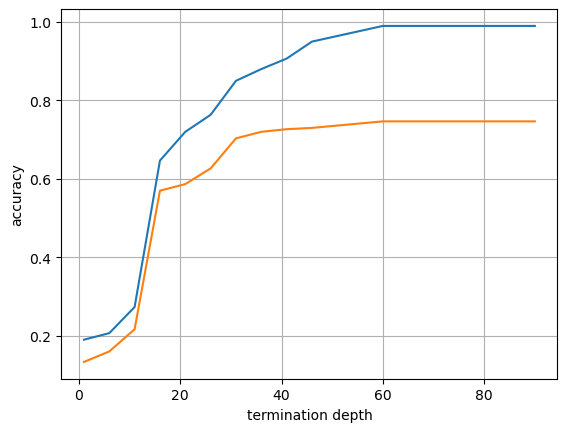

In [69]:
pylab.grid()

pylab.xlabel('termination depth')
pylab.ylabel('accuracy')
pylab.plot(arr_res[:,0],arr_res[:,1])
pylab.plot(arr_res[:,0],arr_res[:,2])
pylab.show()

#### 10 деревьев, подвыборки равны по длине выборке, d = 0.5

In [30]:
arr_res = []
for i in range(1,50,5):
    rf = random_forest(trees_count = 10,max_depth = i,sel_size = 1)
    pipe = Pipeline([('transformer',transform()),('classifier',rf)])
    pipe.fit(larrDC,larrLB)
    
    arr_res.append([i,pipe.score(larrDC,larrLB),pipe.score(tarrDC,tarrLB)])
    print("{}".format(i))

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


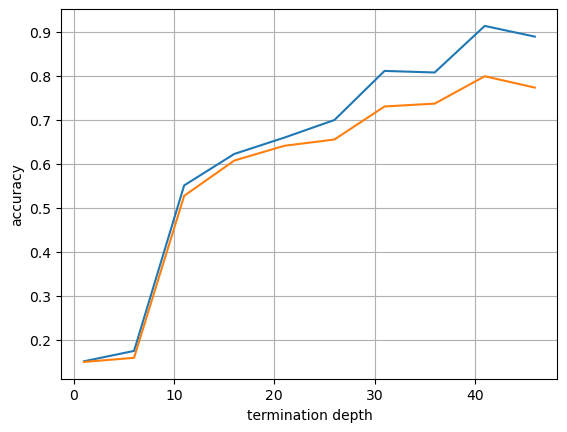

In [31]:
arr_res = np.array(arr_res,dtype = object)
res_arr = []
for i in arr_res:
    res_arr.append([i[0],i[1][0],i[2][0]])
res_arr = np.array(res_arr)

pylab.grid()

pylab.xlabel('termination depth')
pylab.ylabel('accuracy')
pylab.plot(res_arr[:,0],res_arr[:,1])
pylab.plot(res_arr[:,0],res_arr[:,2])
pylab.show()

#### Кросс-валидация случайного леса

In [148]:
larrLB,larrDC,tarrLB,tarrDC = create_dataset(ClLen = 200)

In [110]:
rf = random_forest(trees_count = 10,max_depth = 40,sel_size = 300,dropout = 0.4)
pipe = Pipeline([('transformer',transform()),('classifier',rf)])
CrossValidataion = RCV([larrDC,larrLB],[tarrDC,tarrLB],pipe = pipe)
arr = CrossValidataion.validate(i = 10)

In [111]:
arr.mean(axis = 0)

array([0.7549285714285715, 0.5524285714285714, 0.5835714285714285,
       0.5590714285714286, 0.5955714285714285, 0.6077142857142858,
       0.5953571428571428, 0.6396428571428572, 0.6069285714285715,
       0.5955714285714286, 0.6138571428571428], dtype=object)

In [106]:
rf = random_forest(trees_count = 10,max_depth = 40,sel_size = 300)
pipe = Pipeline([('transformer',transform()),('classifier',rf)])
CrossValidataion = RCV([larrDC,larrLB],[tarrDC,tarrLB],pipe = pipe)
arr = CrossValidataion.validate(i = 10)

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [107]:
arr.mean(axis = 0)

array([0.822642857142857, 0.7337857142857144, 0.7256428571428571,
       0.7203571428571428, 0.7150714285714285, 0.7225, 0.7182857142857143,
       0.7072142857142858, 0.7151428571428571, 0.7145714285714286, 0.7155],
      dtype=object)

In [149]:
rf = random_forest(trees_count = 30,max_depth = 50,sel_size = 400)
pipe = Pipeline([('transformer',transform()),('classifier',rf)])
CrossValidataion = RCV([larrDC,larrLB],[tarrDC,tarrLB],pipe = pipe)
arr = CrossValidataion.validate(i = 10,ratio = 0.95,verbal = True)

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


test 0 of 10 | done
test 1 of 10 | done
test 2 of 10 | done
test 3 of 10 | done
test 4 of 10 | done
test 5 of 10 | done
test 6 of 10 | done
test 7 of 10 | done
test 8 of 10 | done
test 9 of 10 | done


In [150]:
arr.mean(axis = 0)

array([0.902857142857143, 0.7271428571428572, 0.7335714285714287,
       0.7114285714285714, 0.7378571428571429, 0.7407142857142857,
       0.7542857142857142, 0.7471428571428571, 0.7785714285714286,
       0.7692857142857142, 0.7392857142857143, 0.7457142857142858,
       0.757142857142857, 0.75, 0.7621428571428571, 0.7564285714285715,
       0.74, 0.7435714285714285, 0.7614285714285713, 0.7428571428571429,
       0.75, 0.7442857142857142, 0.7671428571428571, 0.7578571428571428,
       0.7507142857142857, 0.745, 0.7649999999999999, 0.7621428571428571,
       0.7478571428571428, 0.7414285714285714, 0.7521428571428571],
      dtype=object)

In [42]:
rf = random_forest(trees_count = 10,max_depth = 40,sel_size = 1)
pipe = Pipeline([('transformer',transform()),('classifier',rf)])
CrossValidataion = RCV([larrDC,larrLB],[tarrDC,tarrLB],pipe = pipe)
arr = CrossValidataion.validate(i = 10)

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [43]:
arr.mean(axis = 0)

array([0.814642857142857, 0.7718571428571429, 0.7622857142857143,
       0.7712857142857142, 0.7487857142857143, 0.7632142857142857,
       0.7630000000000001, 0.766, 0.7600714285714286, 0.7625,
       0.7677142857142856], dtype=object)

## Встроенный граниентный бустинг

In [70]:
gb_skl = ensemble.GradientBoostingClassifier()
pipe = Pipeline([('transformer',transform()),('classifier',gb_skl)])
pipe.fit(larrDC,larrLB)

print(pipe.score(larrDC,larrLB))
print(pipe.score(tarrDC,tarrLB))

0.9414285714285714
0.8357142857142857


train set:
Confusion matrix, without normalization


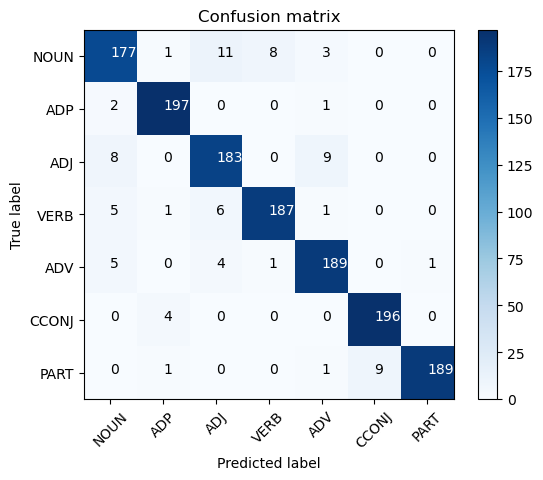

test set:
Confusion matrix, without normalization


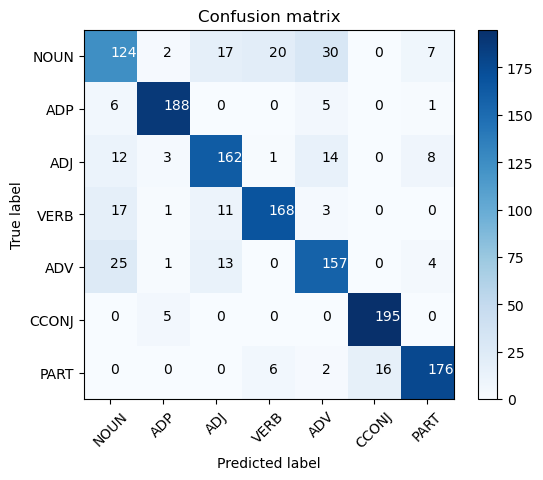

In [71]:
print("train set:")
confusion_matrix(pipe,larrDC,larrLB,class_names = Classes,normalize = False,shrink = 1)
print("test set:")
confusion_matrix(pipe,tarrDC,tarrLB,class_names = Classes,normalize = False,shrink = 1)

#### Кросс-валидация

In [145]:
larrLB,larrDC,tarrLB,tarrDC = create_dataset(ClLen = 1000)

In [146]:
gb_skl = ensemble.GradientBoostingClassifier()
pipe = Pipeline([('transformer',transform()),('classifier',gb_skl)])
CrossValidataion = RCV([larrDC,larrLB],[tarrDC,tarrLB],pipe = pipe)
arr = CrossValidataion.validate(i = 10,ratio = 0.80)

In [147]:
arr.mean(axis = 0)

0.9031785714285714